# Intro

## Installs

In [1]:
!git clone --recursive https://github.com/Microsoft/LightGBM 
%cd LightGBM 
!mkdir build
%cd build
!cmake -DUSE_GPU=1 ..
!make -j4
!pip uninstall lightgbm
!cd ../python-package/ && python setup.py install
!pip install sklego
!pip install xgboost --upgrade

Cloning into 'LightGBM'...
remote: Enumerating objects: 26986, done.
remote: Counting objects: 100% (4119/4119), done.
remote: Compressing objects: 100% (382/382), done.
remote: Total 26986 (delta 3904), reused 3808 (delta 3731), pack-reused 22867
Receiving objects: 100% (26986/26986), 19.38 MiB | 13.56 MiB/s, done.
Resolving deltas: 100% (20016/20016), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21733, done.        
remote: Counting objects: 100% (5/5), done.        
remot

In [2]:
%cd ../../

/content


## Imports

In [3]:
import os, gc
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from lightgbm import LGBMClassifier

import xgboost as xgb

from sklego.mixture import BayesianGMMClassifier

from drive.MyDrive.Kaggle.Clustering_072022.src import functions

import warnings # suppress warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Configs

In [29]:
class CFG:
    path = 'drive/MyDrive/Kaggle/Clustering_072022/'
    seed = 0
    clusters = 7
    splits = 5
    thresh = 0.85

## Loading & Transforming Data

In [30]:
data = pd.read_csv(CFG.path + 'src/data_removed.csv', index_col='id')

best_cols = data.columns
cat_feats = data.columns[data.dtypes == 'int'].tolist()
num_feats = data.columns[data.dtypes == 'float'].tolist()

# data[num_feats] = RobustScaler().fit_transform(data[num_feats])
df_scaled = pd.DataFrame(PowerTransformer().fit_transform(data), columns=data.columns)

In [31]:
functions.set_seed(0)

pred_probs = functions.soft_voting(10, df_scaled, best_cols, with_replace=True, max_iter=400, tol=0.0005, n_init=3)
pickle.dump(pred_probs, open(CFG.path+'src/ensemble_pkls/E#5-bootstrapT-mi400-t0.0005-ni3-iters10_pred_probs.pkl', 'wb'))
# pred_probs = pickle.load(open(CFG.path+'src/E#2pred_probs_n50.pkl', 'rb'))

========= 0 ==========
David Bouldin score: 3.6251
Calinski Harabasz score: 3789.823
========= 1 ==========
David Bouldin score: 3.6122
Calinski Harabasz score: 3813.287
========= 2 ==========
David Bouldin score: 3.6116
Calinski Harabasz score: 3814.023
========= 3 ==========
David Bouldin score: 3.6144
Calinski Harabasz score: 3808.797
========= 4 ==========
David Bouldin score: 3.6142
Calinski Harabasz score: 3807.999
========= 5 ==========
David Bouldin score: 3.6106
Calinski Harabasz score: 3810.978
========= 6 ==========
iteration 6 could not determine the cluster label mapping, skipping
========= 7 ==========
David Bouldin score: 3.6132
Calinski Harabasz score: 3809.801
========= 8 ==========
David Bouldin score: 3.6133
Calinski Harabasz score: 3810.923
========= 9 ==========
David Bouldin score: 3.6101
Calinski Harabasz score: 3812.016


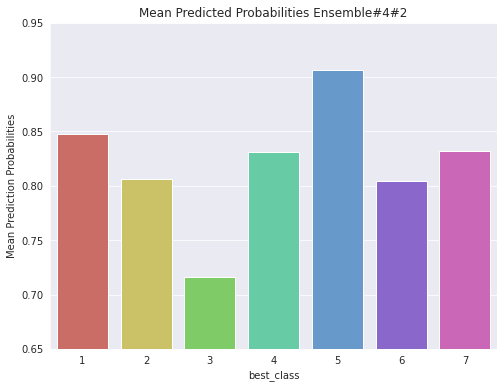

In [32]:
cluster_class_probs = functions.best_class(pred_probs)
confidence_s = cluster_class_probs.groupby('best_class')['highest_prob'].mean()
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=confidence_s.index, y=confidence_s.values, palette=sns.color_palette('hls', 7))
ax.set_ylabel('Mean Prediction Probabilities')
ax.set_ylim([0.65, 0.95])
plt.title('Mean Predicted Probabilities Ensemble#4#2')
plt.show()

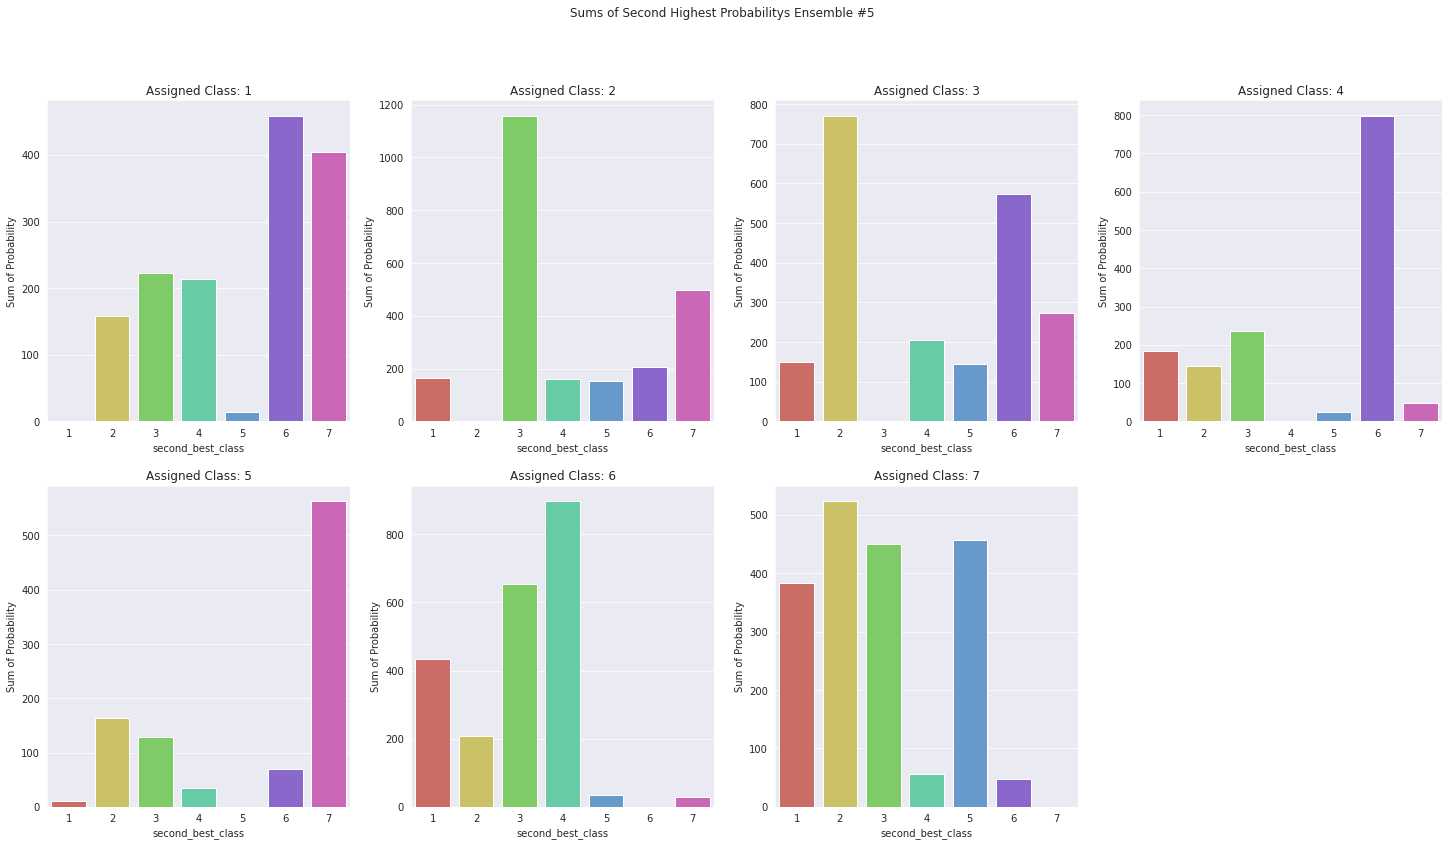

In [33]:
functions.second_highest(cluster_class_probs, 'Sums of Second Highest Probabilitys Ensemble #5')

# Confidence Threshold Filtering

In [34]:
confident_predictions = cluster_class_probs.loc[cluster_class_probs['highest_prob'] >= CFG.thresh]
confident_preds_class = confident_predictions['best_class']
df_scaled['class'] = confident_preds_class

train_df = df_scaled.loc[df_scaled["class"] == df_scaled["class"]]
test_df = df_scaled.loc[df_scaled["class"] != df_scaled["class"]]

X = train_df.drop(columns="class").reset_index(drop=True)
y = train_df["class"].reset_index(drop=True)
X_test = test_df.drop(columns="class").reset_index(drop=True)
X_full = df_scaled.drop(columns="class")

# Model Definitions

In [35]:
svc_params = pickle.load(open('/content/drive/MyDrive/Kaggle/Clustering_072022/src/svc_params.pkl', 'rb'))
et_params= pickle.load(open('/content/drive/MyDrive/Kaggle/Clustering_072022/src/et_params.pkl', 'rb'))
knn_params = pickle.load(open('/content/drive/MyDrive/Kaggle/Clustering_072022/src/knn_params.pkl', 'rb'))
qda_params = pickle.load(open('/content/drive/MyDrive/Kaggle/Clustering_072022/src/qda_params.pkl', 'rb'))
lgb_params = pickle.load(open('/content/drive/MyDrive/Kaggle/Clustering_072022/src/lgb_params.pkl', 'rb'))
xgb_params = pickle.load(open('/content/drive/MyDrive/Kaggle/Clustering_072022/src/xgboost_params.pkl', 'rb'))

In [36]:
params_xgb = {
    'booster': 'gbtree',
    'num_class': 7,
    'gpu_id': 0,
    'tree_method': 'gpu_hist',
    'predictor': 'gpu_predictor',
    'num_boost_round' : 20000,
    'early_stopping_rounds' : 200
    }

In [37]:
et = ExtraTreesClassifier(
    n_jobs = -1,
    random_state=CFG.seed,
    bootstrap=True,
    **et_params
    )

lgb = LGBMClassifier(
    objective = 'multiclass',
    n_estimators = 5000,
    random_state = CFG.seed,
    n_jobs = -1,
    device_type='gpu',
    **lgb_params
    )

qda = QuadraticDiscriminantAnalysis(
    priors=CFG.clusters,
    **qda_params
    )

bgmm = BayesianGMMClassifier(
            n_components=CFG.clusters,
            random_state = CFG.seed,
            tol = 0.001,
            covariance_type = 'full',
            max_iter = 300,
            n_init=4,
            init_params='kmeans'
            )

xgbc = xgb.XGBClassifier(
    params_xgb, 
    objective='multi:softprob'
    )

svc = SVC(
    **svc_params, 
    probability=True
    )

In [38]:
models = {"ET":et, "LGBM":lgb, "QDA":qda, "BGMM_C":bgmm, "SVC": svc, "XGB": xgbc} 

# Kfold Classification

# Predict Everything

In [39]:
def fit_predict_everything():
    preds = []
    model_names = []
    scores = []
    for model_name, model in models.items():
        print('===', model_name, '===')

        if model_name == 'XGB':
            xy = y.astype(int)-1
            model.fit(X[best_cols], xy)
            preds_prob = model.predict_proba(X_full[best_cols])
        else:
            model.fit(X[best_cols], y)
            preds_prob = model.predict_proba(X_full[best_cols])

        preds_prob_df = pd.DataFrame(preds_prob, columns=range(1, 8), index=df_scaled.index)
        db, ch = functions.score_clusters(df_scaled[best_cols], preds_prob_df.idxmax(axis=1), verbose=True)
        scores.append((db, ch))
        preds.append(preds_prob_df)
        model_names.append(model_name)

    return preds, model_names, scores

In [40]:
predictions, model_names, scores = fit_predict_everything()

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [41]:
cluster_class_probs = cluster_class_probs.loc[:, [1, 2, 3, 4, 5, 6, 7]]
predictions.append(cluster_class_probs)
model_names.append('BGMM')

db, ch = functions.score_clusters(df_scaled[best_cols], cluster_class_probs.idxmax(axis=1), verbose=True)
scores.append((db, ch))

David Bouldin score: 3.6101
Calinski Harabasz score: 3812.016


# Combine Predictions

In [42]:
pred_dict = dict(zip(model_names, predictions))
pickle.dump(pred_dict, open(CFG.path+'src/ensemble_pkls/E#5pred_dict.pkl', 'wb'))

In [43]:
#chosen fairly randomly
predictions_df = 0.5 * pred_dict['ET'] + 1.5 * pred_dict['LGBM'] + 0.5 * pred_dict['QDA'] + 1.5 * pred_dict['BGMM_C'] + 0.5 * pred_dict['BGMM'] + 0.5 * pred_dict['SVC']  + 1.0 * pred_dict['XGB']

#normalise so rows sums to 1
predictions_df = predictions_df.div(predictions_df.sum(axis=1), axis=0)
predictions_df = functions.best_class(predictions_df)
pickle.dump(predictions_df, open(CFG.path+'src/ensemble_pkls/E#5pred_df_0.5-1.5-0.5-1.5-0.5-0.5-1.0.pkl', 'wb'))

# Analyze Predicted

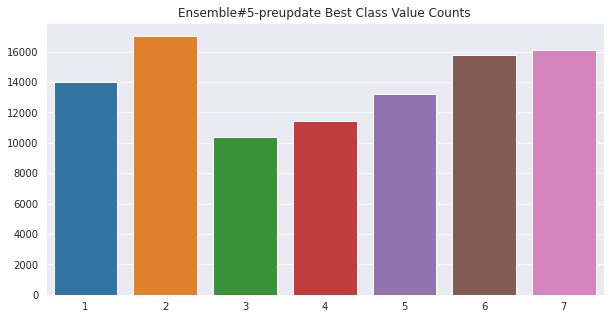

In [44]:
fig, ax = plt.subplots(figsize=(10,5))
val_c = predictions_df["best_class"].value_counts()
sns.barplot(x=val_c.index, y=val_c.values)
plt.title('Ensemble#5-preupdate Best Class Value Counts')
plt.show()

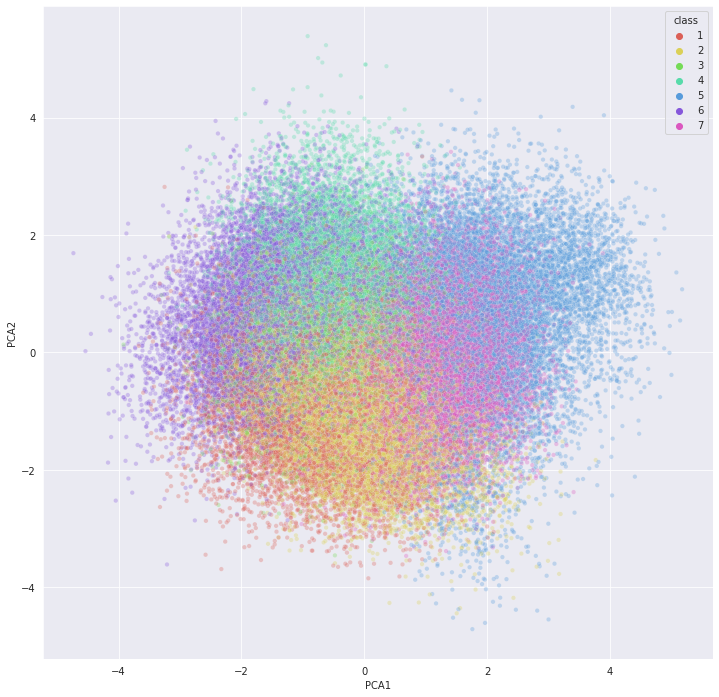

In [45]:
pca = PCA(n_components=2, random_state=10)
X_pca = pca.fit_transform(df_scaled[best_cols])
pca_df = pd.DataFrame({'PCA1': X_pca[:, 0], 'PCA2': X_pca[:, 1]})
pca_df['class'] = predictions_df['best_class']

fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='class', s=20, alpha=0.3, palette=sns.color_palette('hls', pca_df['class'].nunique()))

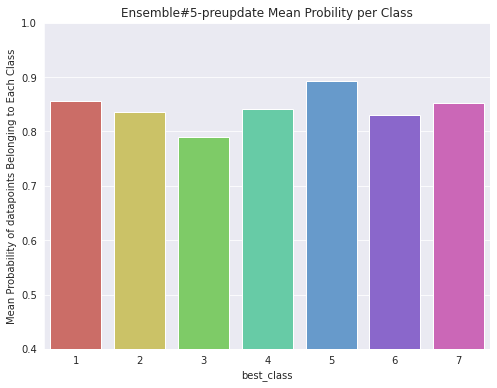

In [46]:
confidence_s = predictions_df.groupby('best_class')['highest_prob'].mean()
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=confidence_s.index, y=confidence_s.values, palette=sns.color_palette('hls', 7))
ax.set_ylabel('Mean Probability of datapoints Belonging to Each Class')
ax.set_ylim([0.4, 1.])
plt.title('Ensemble#5-preupdate Mean Probility per Class')
plt.show()

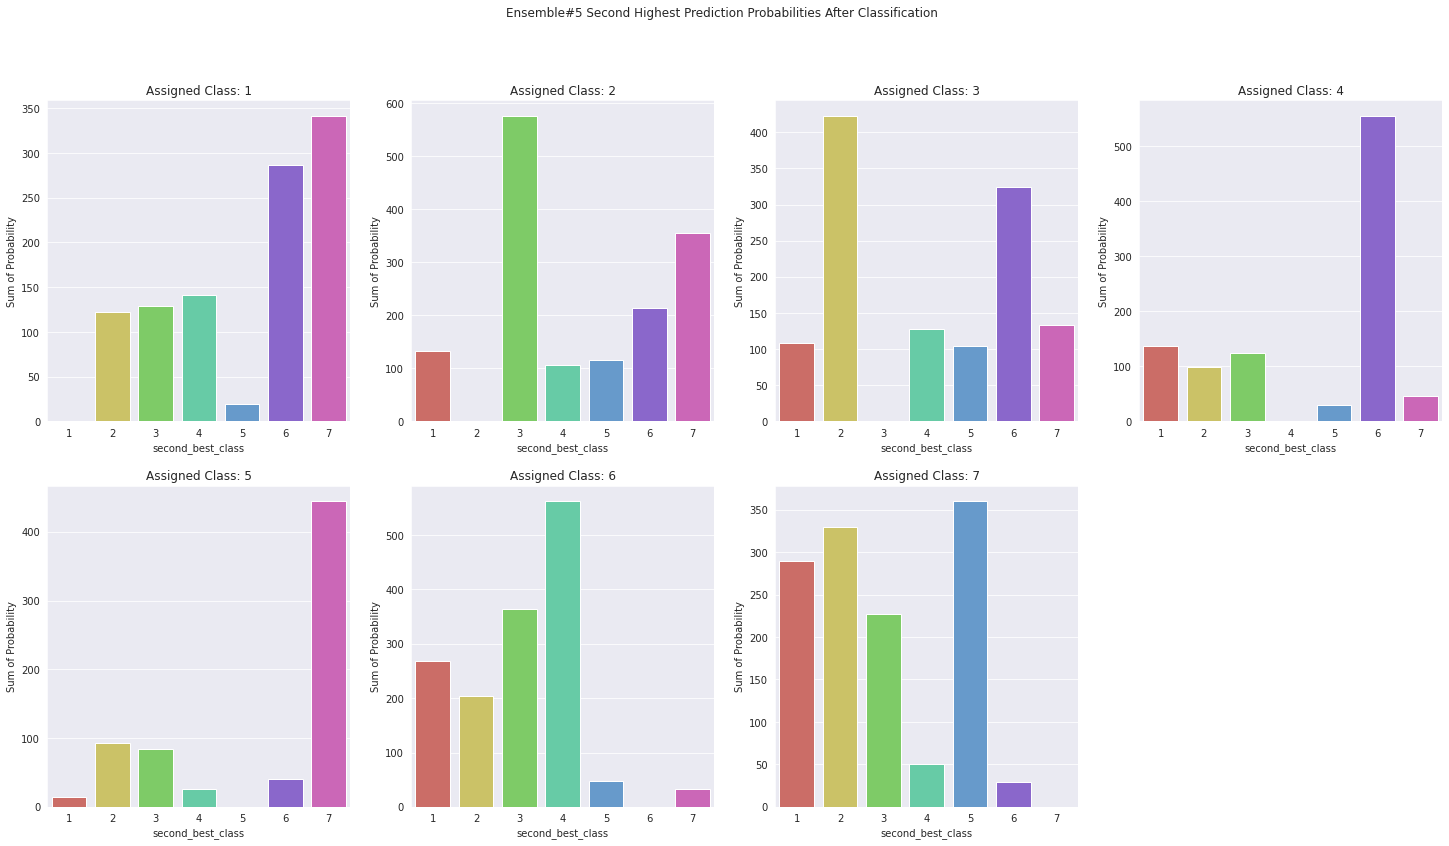

In [47]:
functions.second_highest(predictions_df, 'Ensemble#5 Second Highest Prediction Probabilities After Classification')

# Update Predictions

In [48]:
def update_predictions(predict_number, y):
    for i in range(predict_number):
        print('==='*6, i, '==='*6)
        X_scaled_sample = df_scaled.sample(60000)
        y_sample = y.loc[X_scaled_sample.index]

        bgmm = BayesianGMMClassifier(
            n_components=7,
            random_state=i,
            n_init=3, max_iter=200,
            tol=0.001,
            init_params='kmeans'
        )
        bgmm.fit(X_scaled_sample[best_cols], y_sample)

        pred_probs = bgmm.predict_proba(df_scaled[best_cols])
        pred_probs = pd.DataFrame(pred_probs, columns=range(1,8))

        functions.score_clusters(df_scaled[best_cols], pred_probs.idxmax(axis=1), verbose=True)
        y = pred_probs.idxmax(axis=1)

    return pred_probs

In [49]:
predicted_probabilities = update_predictions(predict_number=10, y=predictions_df["best_class"])

================== 0 ==================
David Bouldin score: 3.6130
Calinski Harabasz score: 3792.653
================== 1 ==================
David Bouldin score: 3.6815
Calinski Harabasz score: 3699.461
================== 2 ==================
David Bouldin score: 3.7353
Calinski Harabasz score: 3646.064
================== 3 ==================
David Bouldin score: 3.7754
Calinski Harabasz score: 3608.759
================== 4 ==================
David Bouldin score: 3.8054
Calinski Harabasz score: 3584.340
================== 5 ==================
David Bouldin score: 3.8240
Calinski Harabasz score: 3565.932
================== 6 ==================
David Bouldin score: 3.8400
Calinski Harabasz score: 3557.399
================== 7 ==================
David Bouldin score: 3.8542
Calinski Harabasz score: 3543.768
================== 8 ==================
David Bouldin score: 3.8588
Calinski Harabasz score: 3544.551
================== 9 ==================
David Bouldin score: 3.8659
Calinski Harab

In [50]:
predictions_df = functions.best_class(predicted_probabilities)

# Updated Predictions Analysis

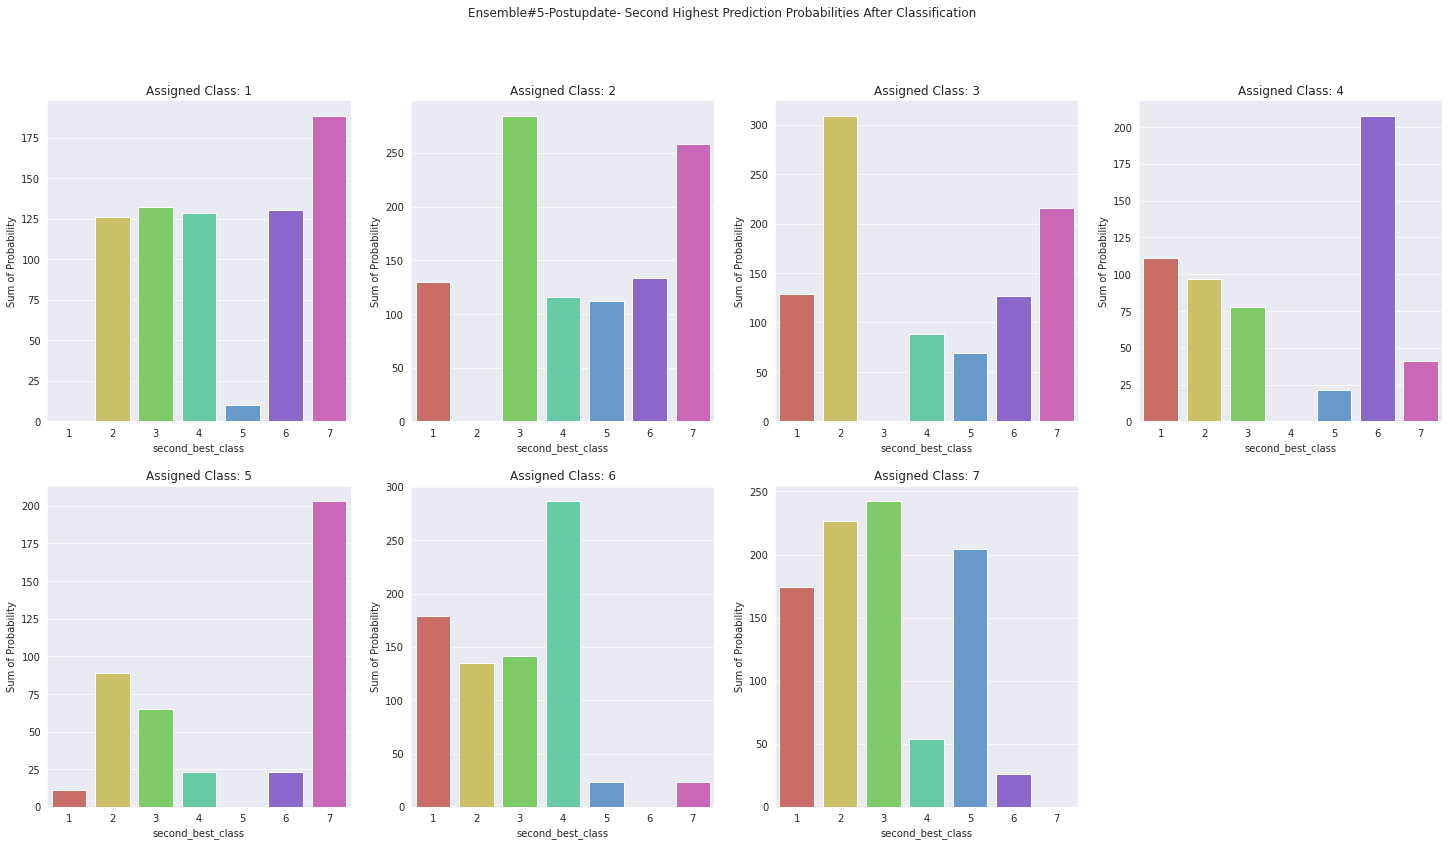

In [51]:
functions.second_highest(predictions_df, 'Ensemble#5-Postupdate- Second Highest Prediction Probabilities After Classification')

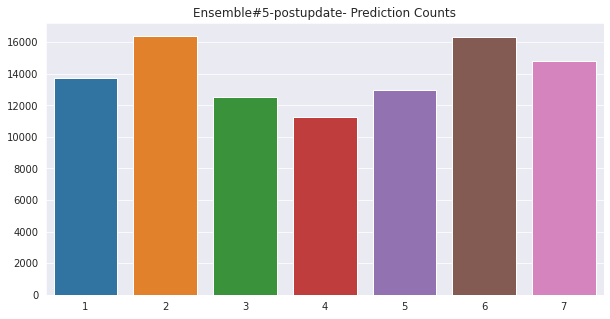

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
val_c = predictions_df['best_class'].value_counts()
sns.barplot(x=val_c.index, y=val_c.values)
plt.title('Ensemble#5-postupdate- Prediction Counts')
plt.show()

In [53]:
submission = pd.read_csv(CFG.path + 'submissions/sample_submission.csv', index_col='Id')
submission['Predicted'] = predictions_df['best_class']
submission.to_csv(CFG.path + 'submissions/ensemble#5-afterupdate(10).csv')